In [1]:
import os
import gc
from sys import getsizeof

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
train_path = "new_train.csv"
image_path = "new_train"
test_path = "test.csv"

In [4]:
class Modelling:
    def __init__(self, train_path, test_path, image_path):
        self.train_data = pd.read_csv(train_path)
        self.test_data = pd.read_csv(test_path) 
        self.image_path = image_path
        self.image_amount = len(os.listdir(image_path))
        self.checkpoint_path = "model_checkpoint.h5"
        
        self.X_train, self.X_val, self.y_train, self.y_val = None, None, None, None
        self.X_test = None

        self.models = {}

        self.optimizer = keras.optimizers.Adam(learning_rate=0.001)
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        self.checkpoint = ModelCheckpoint(self.checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        
    def prepare_data(self, start, end):
        amount_of_images = end - start
        scaler = StandardScaler() 
        
        X = self.train_data.drop(['Price'], axis=1)
        y = self.train_data['Price']
        
        X_scaled = scaler.fit_transform(X)

        images = np.empty((amount_of_images, 512, 512, 3), dtype=np.uint8)
        for i, image in enumerate(os.listdir(self.image_path)[start:end]):
            image = cv.imread(f'{self.image_path}/{image}')
            images[i, ...] = image

        self.X_train_csv, self.X_val_csv, self.X_train_img, self.X_val_img, self.y_train, self.y_val = \
        train_test_split(X_scaled[start:end], images, y[start:end], test_size=0.2, random_state=42)
        
        #Standariseren 
        self.X_test = scaler.transform(self.test_data)

    def train_NN(self):
        if all(data is not None for data in [self.X_train_csv, self.X_val_csv, self.y_train, self.y_val, self.X_test]):
            self.models['NN'] = keras.Sequential()
            
            self.models['NN'].add(layers.Dense(256, activation='relu', input_shape=(self.X_train_csv.shape[1],)))
            self.models['NN'].add(layers.Dropout(0.5))
            self.models['NN'].add(layers.Dense(128, activation='relu'))
            self.models['NN'].add(layers.Dropout(0.3))
            self.models['NN'].add(layers.Dense(64, activation='relu'))
            self.models['NN'].add(layers.Dense(1))
            
            self.models['NN'].compile(optimizer=self.optimizer, loss='mean_absolute_percentage_error')
            
            self.models['NN'].fit(self.X_train_csv, self.y_train, epochs=50, batch_size=32, \
                                  validation_data=(self.X_val_csv, self.y_val), callbacks=[self.early_stopping])
        else:
            print("Data is not prepared... run prepare_data() first!")

    def create_CNN(self):
        img_input = layers.Input(shape=(512, 512, 3))
        csv_input = layers.Input(shape=(6))
        
        # define layers for image data 
        x_img = layers.experimental.preprocessing.Rescaling(1./255)(img_input)
        x_img = layers.Conv2D(16, 3, padding='same', activation='relu')(x_img)
        x_img = layers.MaxPooling2D()(x_img)
        x_img = layers.Conv2D(32, 3, padding='same', activation='relu')(x_img)
        x_img = layers.MaxPooling2D()(x_img)
        x_img = layers.Conv2D(64, 3, padding='same', activation='relu')(x_img)
        x_img = layers.MaxPooling2D()(x_img)
        x_img = layers.Flatten()(x_img)
        
        # define layers for csv data
        x_csv = layers.Flatten()(csv_input)
        x_csv = layers.Dense(16, activation='relu')(x_csv)
        x_csv = layers.Dense(32, activation='relu')(x_csv)
        x_csv = layers.Dense(64, activation='relu')(x_csv)
        
        # merge layers
        x = layers.concatenate([x_img, x_csv])
        x = layers.Dense(128, activation='relu')(x)
        output = layers.Dense(1)(x)
        
        # make model with 2 inputs and 1 output
        self.models['CNN'] = tf.keras.models.Model(inputs=[img_input, csv_input], outputs=output)

        self.models['CNN'].compile(optimizer=self.optimizer, loss='mean_absolute_percentage_error')

        try:
            self.models['CNN'].load_weights(self.checkpoint_path)
        except:
            print('No previous weights loaded...')

    def train_CNN(self, batch_size=1000):
        self.create_CNN()
        for i in range(0, self.image_amount, batch_size):
            start = i
            end = min(i + batch_size, self.image_amount)
            print(f'Training on images {start} to {end}')
    
            # Clear TensorFlow session
            tf.keras.backend.clear_session()
            
            self.prepare_data(start, end)
            
            self.models['CNN'].fit([self.X_train_img, self.X_train_csv], self.y_train, epochs=50, batch_size=16, \
                               validation_data=([self.X_val_img, self.X_val_csv], self.y_val), \
                               callbacks=[self.early_stopping, self.checkpoint])

            gc.collect()
            
    def evaluate_models(self):
        if self.models:
            fig, ax = plt.subplots(1, 2)
            for name, model in self.models.items():
                plt.tight_layout()
                ax[0].plot(model.history.history['loss'], label=f'{name} Train Loss')
                ax[0].set_xlabel('Epochs')
                ax[0].set_ylabel('Mean Absolute Percentage Error (mape)')
                ax[0].legend()
                
                ax[1].plot(model.history.history['val_loss'], label=f'{name} Val Loss')
                ax[1].set_xlabel('Epochs')
                ax[1].set_ylabel('Mean Absolute Percentage Error (mape)')
                ax[1].legend()
        else:
            print('No models trained...')
            

In [5]:
modelling = Modelling(train_path, test_path, image_path)

In [6]:
# modelling.train_NN()

In [7]:
modelling.train_CNN()

Training on images 0 to 1000
Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 40.2606
Epoch 1: val_loss improved from inf to 38.05849, saving model to model_checkpoint.h5
50/50 [==============================] - 14s 128ms/step - loss: 40.2606 - val_loss: 38.0585
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 36.2697
Epoch 2: val_loss improved from 38.05849 to 37.61014, saving model to model_checkpoint.h5
50/50 [==============================] - 5s 110ms/step - loss: 36.2697 - val_loss: 37.6101
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 35.6054
Epoch 3: val_loss improved from 37.61014 to 37.50724, saving model to model_checkpoint.h5
50/50 [==============================] - 5s 109ms/step - loss: 35.6054 - val_loss: 37.5072
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 34.9969
Epoch 4: val_loss did not improve from 37.50724
50/50 [==============================] - 4s 88ms/step - loss: 34.9969 - val_loss

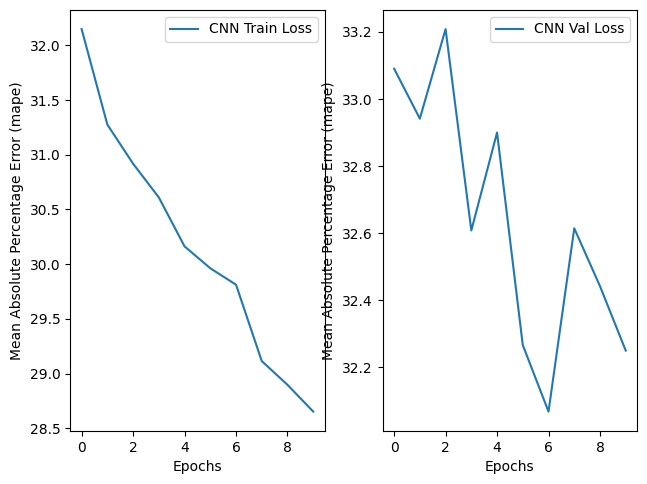

In [8]:
modelling.evaluate_models()